In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RepeatedKFold

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor

from scipy.stats import pearsonr
from sklearn.datasets import make_classification

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

# Getting data from scraped csv file

In [ ]:
df = pd.read_csv("WineData.csv")
df.loc[df["Type"] == 2]

# Cleaning the data

In [3]:
df.columns

Index(['Unnamed: 0', 'Id', 'Name', 'Price', 'Rating', 'NumRatings', 'Type',
       'StyleName', 'Year', 'Body', 'Acidity', 'Vintage', 'Nat', 'Region',
       'Country', 'Size', 'Winery'],
      dtype='object')

In [4]:
#Drop all categorical/useless columns
numeric = df.drop(columns=['Unnamed: 0', 'Id', 'Name', 'StyleName', 'Region', 'Winery'])
#Drop all records with body or acidity = -1
numeric = numeric.loc[~((numeric["Body"] == -1) | (numeric["Acidity"] == -1) | (numeric["Year"] <= 0))]
numeric.head()

,Price,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Country,Size
0,5.02,3.5,1957,1,2011,4,3,0,0,United States,500
1,5.49,3.2,3101,1,2016,4,3,0,0,United States,750
2,5.49,3.2,1466,1,2016,3,3,0,0,United States,750
3,5.25,3.8,50,4,2017,3,2,0,0,United States,750
6,7.08,3.7,7880,4,2018,3,2,0,0,United States,750


In [5]:
#Making dummy columns for each country
countries = numeric.Country.unique()

for country in countries:
    numeric[country] = np.where(numeric["Country"] == country, 1, 0)

In [6]:
#Remove country column and make final cleaned data
data = numeric.drop(columns=["Country"])
data.reset_index(inplace=True,drop=True)
data.head()

,Price,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size,...,NONE,Greece,Uruguay,Mexico,New Zealand,Germany,Hungary,Austria,Brazil,United Kingdom
0,5.02,3.5,1957,1,2011,4,3,0,0,500,...,0,0,0,0,0,0,0,0,0,0
1,5.49,3.2,3101,1,2016,4,3,0,0,750,...,0,0,0,0,0,0,0,0,0,0
2,5.49,3.2,1466,1,2016,3,3,0,0,750,...,0,0,0,0,0,0,0,0,0,0
3,5.25,3.8,50,4,2017,3,2,0,0,750,...,0,0,0,0,0,0,0,0,0,0
4,7.08,3.7,7880,4,2018,3,2,0,0,750,...,0,0,0,0,0,0,0,0,0,0


# TODO: Remove Outliers

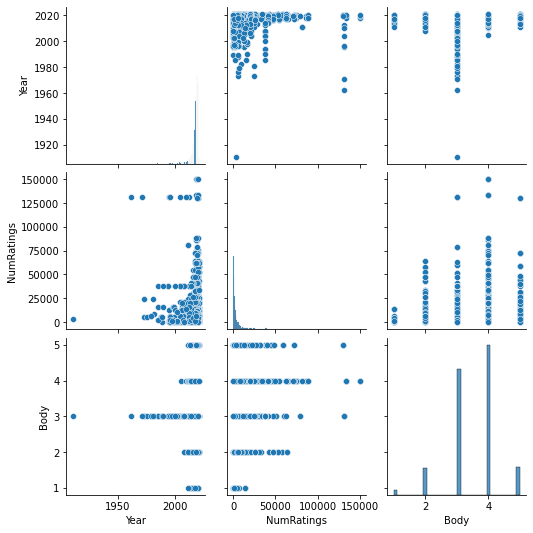

In [7]:
import seaborn as sns


#Plotting all continuous variables against eachother
continuous = data[["Year", "NumRatings", "Body"]]
# continuous["log_price"] = np.log(data["Price"])
# continuous["log_rating"] = np.log(data["Rating"])
# continuous["log_year"] = np.log(data["Year"])
# continuous["log_numratings"] = np.log(data["NumRatings"])
# continuous["log_body"] = np.log(data["Body"])
sns.pairplot(continuous)

# Transforming to log price, splitting response and predictors

In [8]:
#Create X and y
#Create log price column
data['log_price'] = np.log(data["Price"])

#X is every column but log price, y is only log price
X = data.drop(columns=["log_price","Price"])
y = data[["log_price"]].values.ravel()
X.head()

,Rating,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size,United States,...,NONE,Greece,Uruguay,Mexico,New Zealand,Germany,Hungary,Austria,Brazil,United Kingdom
0,3.5,1957,1,2011,4,3,0,0,500,1,...,0,0,0,0,0,0,0,0,0,0
1,3.2,3101,1,2016,4,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
2,3.2,1466,1,2016,3,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
3,3.8,50,4,2017,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
4,3.7,7880,4,2018,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0


# Tree based methods side-by-side

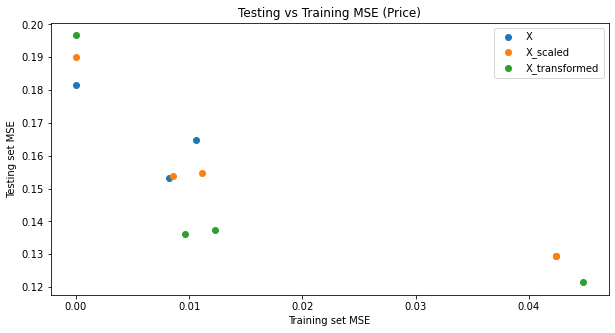

In [46]:
models = list()
models.append(DecisionTreeRegressor())
models.append(BaggingRegressor())
models.append(RandomForestRegressor())
models.append(GradientBoostingRegressor())

#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = pd.DataFrame(X_transformed[:, :15])

plt.figure(figsize=(10,5))
for i,x in enumerate([X, X_scaled, X_transformed]):
    index = int(len(data)*(2/3))
    X_train, X_test = x.iloc[:index,:], x.iloc[index:, :]
    y_train, y_test = y[:index], y[index:]
    
    train_errors = []
    test_errors = []
    for model in models:
        model = model.fit(X_train,y_train)
        

        y_train_hat = model.predict(X_train)
        y_test_hat = model.predict(X_test)

        train_errors.append(np.mean((y_train_hat - y_train) **2))
        test_errors.append(np.mean((y_test_hat - y_test) **2))
#         train_errors.append(model.score(X_train,y_train))
#         test_errors.append(model.score(X_test,y_test))
#         print(type(model).__name__)
#         print(train_errors[-1], test_errors[-1])

    plt.scatter(train_errors, test_errors)


plt.title("Testing vs Training MSE (Price)")
plt.xlabel("Training set MSE")
plt.ylabel("Testing set MSE")
plt.legend(labels=["X", "X_scaled", "X_transformed"])
plt.show()

# KFold on Gradient Boosing with PCA transformation, to determine how many PCS to keep in data

In [10]:
def scoring(estimator, X, y):
    y_hat = estimator.predict(X)
    return np.mean((y_hat-y)**2)

[0.06959045 0.0631274  0.06298646 0.08282782 0.06810289 0.07352053
 0.09615346 0.101479   0.08041274 0.07040047]
[0.07164752 0.06295861 0.06176256 0.08221104 0.06727082 0.07343967
 0.09424723 0.09961095 0.07971397 0.0696475 ]
[0.07061226 0.06070364 0.06393042 0.08341508 0.06556355 0.07419017
 0.09634447 0.10040512 0.08043497 0.06911115]
[0.07099902 0.06172136 0.06294496 0.08176803 0.06773717 0.07409573
 0.09824306 0.10019034 0.07821932 0.06971102]
[0.06814991 0.06078068 0.06354651 0.08274771 0.0646056  0.07608653
 0.09623859 0.1017797  0.07614287 0.06848337]
[0.06974446 0.06088164 0.06282634 0.0854589  0.06412099 0.07618653
 0.0932427  0.10168882 0.07868153 0.06809227]
[0.06867601 0.06013472 0.06232677 0.08785372 0.06232581 0.07431007
 0.09303441 0.1011466  0.07757643 0.06767047]
[0.06942055 0.059446   0.06097015 0.08809014 0.0623769  0.07127098
 0.09303194 0.09774998 0.07676432 0.06768687]
[0.06833657 0.05925319 0.06283614 0.08883842 0.06361077 0.07231507
 0.09026246 0.10329866 0.0772

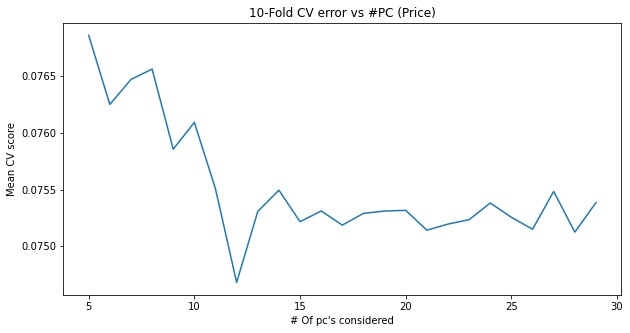

In [47]:
model = GradientBoostingRegressor()

mean_scores = []
npcs = list(range(5,30))
k=10
for n in npcs:
    cv = KFold(n_splits=k, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_transformed.iloc[:,:n], y, scoring = scoring, cv=cv, n_jobs=-1)
    print(scores)
    mean_scores.append(np.mean(scores))
    
plt.figure(figsize=(10,5))
plt.plot(npcs, mean_scores)
plt.title(f"{k}-Fold CV error vs #PC (Price)")
plt.xlabel("# Of pc's considered")
plt.ylabel("Mean CV score")
plt.show()

In [48]:
npcs[np.argmin(mean_scores)]

12

In [49]:
#We choose number of pcs = 12 based on graph above
#validation set
X_val = X_transformed.iloc[:,:13]

index = int(3/4 * len(X_val))
X_train, X_test = X_val.iloc[:index, :], X_val.iloc[index:,:]
y_train, y_test = y[:index], y[index:]

model = GradientBoostingRegressor()
model.fit(X_train,y_train)

y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
train_mse = np.mean((y_train_hat - y_train)**2)
test_mse = np.mean((y_test_hat - y_test)**2)
print(f"Train MSE : {train_mse}")
print(f"Test MSE : {test_mse}")

print(f"Train model R^2 : {model.score(X_train, y_train)}")
print(f"Test model R^2 : {model.score(X_test, y_test)}")

Train MSE : 0.04343407234576432
Test MSE : 0.12567374010113164
Train model R^2 : 0.9368181109513091
Test model R^2 : 0.7474502519355692


# Regression analysis for predicting log rating

In [50]:
#Create X and y
#Create log price column
data['log_rating'] = np.log(data["Rating"])

#X is every column but log price, y is only log price
X = data.drop(columns=["log_rating","Rating",'log_price'])
y = data[["log_rating"]].values.ravel()
X.head()

,Price,NumRatings,Type,Year,Body,Acidity,Vintage,Nat,Size,United States,...,NONE,Greece,Uruguay,Mexico,New Zealand,Germany,Hungary,Austria,Brazil,United Kingdom
0,5.02,1957,1,2011,4,3,0,0,500,1,...,0,0,0,0,0,0,0,0,0,0
1,5.49,3101,1,2016,4,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
2,5.49,1466,1,2016,3,3,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
3,5.25,50,4,2017,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0
4,7.08,7880,4,2018,3,2,0,0,750,1,...,0,0,0,0,0,0,0,0,0,0


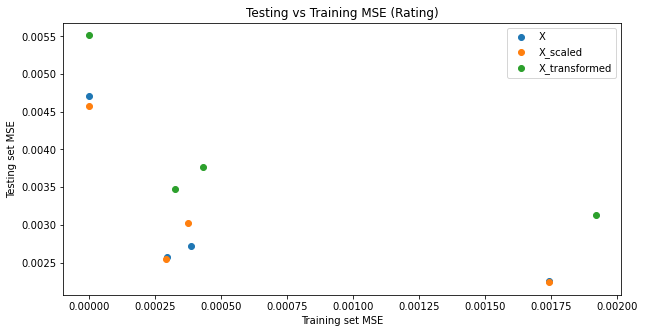

In [53]:
models = list()
models.append(DecisionTreeRegressor())
models.append(BaggingRegressor())
models.append(RandomForestRegressor())
models.append(GradientBoostingRegressor())

#Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

#Transform X
pca_scaled = PCA(n_components=len(list(X_scaled.columns)))
X_transformed = pca_scaled.fit_transform(X_scaled)
X_transformed = pd.DataFrame(X_transformed[:, :15])

plt.figure(figsize=(10,5))
for i,x in enumerate([X, X_scaled, X_transformed]):
    index = int(len(data)*(2/3))
    X_train, X_test = x.iloc[:index,:], x.iloc[index:, :]
    y_train, y_test = y[:index], y[index:]
    
    train_errors = []
    test_errors = []
    for model in models:
        model = model.fit(X_train,y_train)
        

        y_train_hat = model.predict(X_train)
        y_test_hat = model.predict(X_test)

        train_errors.append(np.mean((y_train_hat - y_train) **2))
        test_errors.append(np.mean((y_test_hat - y_test) **2))
#         train_errors.append(model.score(X_train,y_train))
#         test_errors.append(model.score(X_test,y_test))
#         print(type(model).__name__)
#         print(train_errors[-1], test_errors[-1])

    plt.scatter(train_errors, test_errors)

plt.title("Testing vs Training MSE (Rating)")
plt.xlabel("Training set MSE")
plt.ylabel("Testing set MSE")
plt.legend(labels=["X", "X_scaled", "X_transformed"])
plt.show()

In [55]:
def scoring(estimator, X, y):
    y_hat = estimator.predict(X)
    return np.mean((y_hat-y)**2)

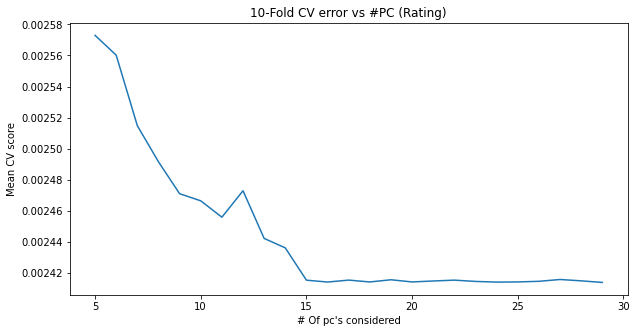

In [57]:
model = GradientBoostingRegressor()

mean_scores = []
npcs = list(range(5,30))
for n in npcs:
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_transformed.iloc[:,:n], y, scoring = scoring, cv=cv, n_jobs=-1)
    mean_scores.append(np.mean(scores))
plt.figure(figsize=(10,5))
plt.plot(npcs, mean_scores)
plt.title(f"{k}-Fold CV error vs #PC (Rating)")
plt.xlabel("# Of pc's considered")
plt.ylabel("Mean CV score")
plt.show()

In [58]:
npcs[np.argmin(mean_scores)]

29

In [60]:
#We choose number of pcs = 12 based on graph above
#validation set
X_val = X

index = int(3/4 * len(X_val))
X_train, X_test = X_val.iloc[:index, :], X_val.iloc[index:,:]
y_train, y_test = y[:index], y[index:]

model = GradientBoostingRegressor()
model.fit(X_train,y_train)

y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
train_mse = np.mean((y_train_hat - y_train)**2)
test_mse = np.mean((y_test_hat - y_test)**2)
print(f"Train MSE : {train_mse}")
print(f"Test MSE : {test_mse}")

print(f"Train model R^2 : {model.score(X_train, y_train)}")
print(f"Test model R^2 : {model.score(X_test, y_test)}")

Train MSE : 0.0017796478638916447
Test MSE : 0.0021767264245767933
Train model R^2 : 0.6956759547756486
Test model R^2 : 0.48756753533108443


# KMeans Clustering

In [ ]:
index = len(data)*(2/3)
X_train, X_test = data.loc[:index,:], data.loc[index:,:]

In [ ]:
X_train, X_test

In [ ]:
#Kmeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)

In [ ]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = X_train.index.values
cluster_map['cluster'] = kmeans.labels_

cluster_indexs = {}
for cluster in range(10):
    cluster_indexs[cluster] = cluster_map[cluster_map.cluster == cluster].data_index.values
cluster_indexs

# Regression Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA

def clean_dataset(df):
    #Drop all categorical/useless columns
    numeric = df.drop(columns=['Unnamed: 0', 'Id', 'Name', 'StyleName', 'Region', 'Winery'])
    #Drop all records with body or acidity = -1
    numeric = numeric.loc[~((numeric["Body"] == -1) | (numeric["Acidity"] == -1) | (numeric["Year"] == 0))]
    numeric.head()

    #Making dummy columns for each country
    countries = numeric.Country.unique()

    for country in countries:
        numeric[country] = np.where(numeric["Country"] == country, 1, 0)

    #Remove country column and make final cleaned data
    data = numeric.drop(columns=["Country"])
    data.reset_index(inplace=True,drop=True)
    return data

def get_dataset(scale=False, pca=False, n_pc=15):
    df = pd.read_csv("WineData.csv")
    df_cleaned = clean_dataset(df)

    #Create X and y
    #Create log price column
    df_cleaned['log_price'] = np.log(df_cleaned["Price"])

    #X is every column but log price, y is only log price
    X = df_cleaned.drop(columns=["log_price","Price"])
    y = df_cleaned[["log_price"]].values.ravel()

    if scale:
        #Scale the data
        scaler = StandardScaler().fit(X)
        X_scaled = scaler.transform(X)
        X = pd.DataFrame(X_scaled, columns=X.columns)

    if pca:
        #PCA transform the data
        pca_scaled = PCA(n_components=len(list(X.columns)))
        X_transformed = pca_scaled.fit_transform(X)
        X = X_transformed[:, :n_pc]

    return X, y

# get a list of models to evaluate
def get_models():
    models = list()
    models.append(LinearRegression())
    models.append(Ridge())
    models.append(Lasso())
    models.append(DecisionTreeRegressor())
    models.append(BaggingRegressor())
    models.append(RandomForestRegressor())
    models.append(GradientBoostingRegressor())
    return models

def scoring(estimator, X, y):
    y_hat = estimator.predict(X)
    return np.mean((y_hat-y)**2)

# evaluate the model using a given test condition
def evaluate_model(cv, model):
    # get the dataset
    #X, y = get_dataset(scale=True,pca=True) #Which dataset? scale, pca params
    # evaluate the model
    scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    # return scores
    return np.mean(scores)

X,y = get_dataset(scale=True, pca = True)

# define test conditions
#ideal_cv = LeaveOneOut()
ideal_cv = KFold(n_splits=50, shuffle=True, random_state=1)
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
    # evaluate model using each test condition
    cv_mean = evaluate_model(cv, model)
    ideal_mean = evaluate_model(ideal_cv, model)
    # check for invalid results
    if np.isnan(cv_mean) or np.isnan(ideal_mean):
        continue
    # store results
    cv_results.append(cv_mean)
    ideal_results.append(ideal_mean)
    # summarize progress
    print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
plt.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = np.polyfit(cv_results, ideal_results, 1)
line = coeff * np.asarray(cv_results) + bias
plt.plot(cv_results, line, color='r')
# label the plot
plt.title('10-fold CV vs LOOCV Mean Accuracy')
plt.xlabel('Mean Accuracy (10-fold CV)')
plt.ylabel('Mean Accuracy (LOOCV)')
# show the plot
plt.show()